In [4]:
from einops import rearrange
from transformer_lens import HookedTransformer

In [5]:
model = HookedTransformer.from_pretrained("gpt2")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [6]:
text = "Persistence is all you need."

In [7]:
tokens = model.to_tokens(text)

In [8]:
_, cache = model.run_with_cache(tokens)

# 2. Logit Attribution

##### Example 1

In [24]:
from einops import rearrange
from transformer_lens import HookedTransformer

In [25]:
model = HookedTransformer.from_pretrained("gpt2")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [26]:
from transformer_lens.utils import get_act_name

In [27]:
final_residual_name = get_act_name("resid_post", 11)

In [28]:
text = "Persistence is all you "

In [29]:
correct_token = rearrange(model.to_tokens("need")[0][-1], "... -> 1 ...")
incorrect_token = rearrange(model.to_tokens("non")[0][-1], "... -> 1 ...")

In [30]:
tokens = model.to_tokens(text)

In [31]:
type(model)

transformer_lens.HookedTransformer.HookedTransformer

In [32]:
tokens, final_residual_name

(tensor([[50256, 30946, 13274,   318,   477,   345,   220]]),
 'blocks.11.hook_resid_post')

In [33]:
correct_token, incorrect_token

(tensor([31227]), tensor([13159]))

Compute the logit difference between the correct and incorrect tokens using\
the difference in the direction of the two tokens in the unembedding matrix

**Hint**: `cache.apply_ln_to_stack(stream, layer=layer_idx, pos_slice=-1)`

In [34]:
from einops import einsum

In [35]:
layer_idx = 11
_, cache = model.run_with_cache(tokens)
final_residual_stream = cache[final_residual_name]

In [36]:
final_residual_stream.shape

torch.Size([1, 7, 768])

In [37]:
final_token_residual_stream = final_residual_stream[:, -1, :]

In [38]:
W_U = model.W_U

In [39]:
W_U.shape

torch.Size([768, 50257])

In [40]:
correct_residual_direction = W_U[:, correct_token]
incorrect_residual_direction = W_U[:, incorrect_token]

In [41]:
scaled_final_token_residual_stream = cache.apply_ln_to_stack(
    final_token_residual_stream,
    layer=layer_idx, pos_slice=-1
)
logit_difference_directions = correct_residual_direction - \
    incorrect_residual_direction

In [42]:
logit_difference_directions.shape,\
scaled_final_token_residual_stream.shape

(torch.Size([768, 1]), torch.Size([1, 768]))

In [43]:
logit_difference = einsum(
    scaled_final_token_residual_stream,
    logit_difference_directions,
    "batch dim, batch dim ->"
)

In [44]:
logit_difference

tensor(1.5007e-11, grad_fn=<ViewBackward0>)

### Logit Lens

##### Example 1

In [24]:
target_positions = [0, 2, 5]

In [26]:
layer_idx = 5

In [48]:
type(cache)

transformer_lens.ActivationCache.ActivationCache

In [49]:
target_positions, len(target_positions)

([0, 2, 5], 3)

In [50]:
layer_idx

5

Return a stack of residual streams up to layer `n` (included it) at positions specified by target_positions

In [51]:
outputs = cache.accumulated_resid(layer=layer_idx, pos_slice=target_positions)

In [52]:
outputs.shape

torch.Size([6, 1, 3, 768])

##### Example 2

In [9]:
import torch

In [106]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
name_pairs = [
    (" Mary", " John"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]
# Define 8 prompts, in 4 groups of 2 (with adjacent prompts having answers swapped)
prompts = [
    prompt.format(name)
    for (prompt, names) in zip(prompt_format, name_pairs) for name in names[::-1]
]
# Define the answers for each prompt, in the form (correct, incorrect)
answers = [names[::i] for names in name_pairs for i in (1, -1)]
# Define the answer tokens (same shape as the answers)
answer_tokens = torch.concat([
    model.to_tokens(names, prepend_bos=False).T for names in answers
])
tokens = model.to_tokens(prompts, prepend_bos=True)

In [107]:
layer_idx = 11

In [108]:
tokens.shape, layer_idx

(torch.Size([8, 15]), 11)

In [109]:
answer_tokens.shape

torch.Size([8, 2])

In [110]:
_, cache = model.run_with_cache(tokens)

In [111]:
target_position = -1

**Step 1:** Calculate the logit difference directions

In [112]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)

In [113]:
answer_residual_directions.shape

torch.Size([8, 2, 768])

In [114]:
correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(dim=1)
logit_diff_directions = correct_residual_directions - incorrect_residual_directions

In [115]:
logit_diff_directions.shape

torch.Size([8, 768])

**Step 2**: Extract the residual streams

In [116]:
accumulated_residuals, labels = cache.accumulated_resid(
    layer=layer_idx, pos_slice=target_position, return_labels=True
)

In [117]:
accumulated_residuals.shape

torch.Size([12, 8, 768])

In [118]:
scaled_accumulated_residuals = cache.apply_ln_to_stack(
    accumulated_residuals, layer=layer_idx, pos_slice=target_position
)

In [119]:
scaled_accumulated_residuals.shape

torch.Size([12, 8, 768])

**Step 3**: Project the residual streams to the logit difference directions

In [120]:
scaled_accumulated_residuals.shape

torch.Size([12, 8, 768])

In [121]:
logit_difference = einsum(
    scaled_accumulated_residuals, logit_diff_directions, "... bs d_model, bs d_model -> ..."
)

In [122]:
from einops import einsum
import plotly.express as px

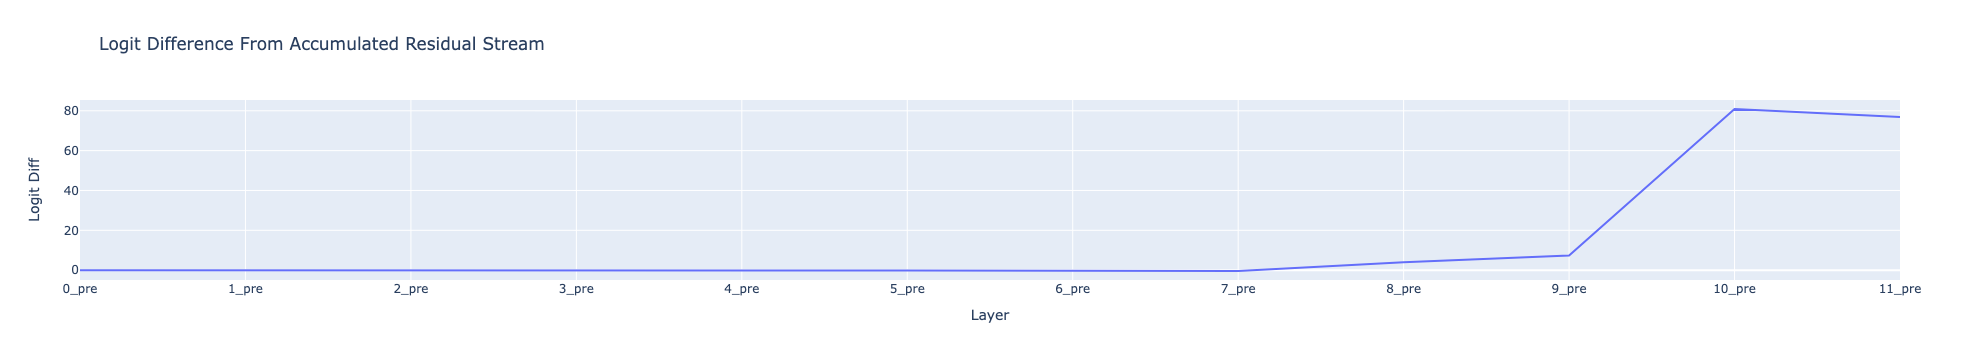

In [123]:
fig = px.line(
    y=logit_difference.detach().numpy(),
    x=labels,
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    width=800
)

fig.show()

### Layer Attribution

In [128]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)

In [129]:
per_layer_residual.shape

torch.Size([26, 8, 768])

In [132]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)

In [134]:
per_head_residual.shape

torch.Size([144, 8, 768])